# Image Classification Imports

In [10]:
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imghdr
import os
import pathlib
import time

AUTOTUNE = tf.data.AUTOTUNE

# Function Definitions

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
def changeFileNames(folder = ""):
    count = 1
    for i in os.listdir(folder):
        source = folder + i
        destination = folder + "Images_" + str(count) + ".jpeg"
        os.rename(source, destination)
        count += 1
    print("All files renamed")

In [13]:
def checkUnableFiles(pathName = ""):
    data_dir = pathlib.Path(pathName)
    image_extensions = [".png", ".jpg"]  # add there all your images file extensions
    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [14]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
    label = gel_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

# Prepare Dataset

In [17]:
data_dir = pathlib.Path("Data/")
jpg_files = list(data_dir.glob("**/*.jpg"))
png_files = list(data_dir.glob("**/*.png"))
jpeg_files = list(data_dir.glob("**/*.jpeg"))
all_files = jpg_files + png_files + jpeg_files

image_count = len(all_files)

In [18]:
image_count

40

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
    print(f.numpy())

b'Data\\non-fresh\\20200517_145834.jpg'
b'Data\\fresh\\20200517_084741.jpg'
b'Data\\non-fresh\\20200517_145857.jpg'
b'Data\\fresh\\20200517_084015.jpg'
b'Data\\fresh\\20200517_085346.jpg'


In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
class_names = ['fresh', 'non-fresh']
print(class_names)

['fresh', 'non-fresh']


In [22]:
def gel_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [23]:
val_size = int(image_count *0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

32
8


In [25]:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls= AUTOTUNE) 

In [26]:
for image, label in train_ds.take(1):
    print("Image Shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image Shape:  (180, 180, 3)
Label:  1


In [27]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

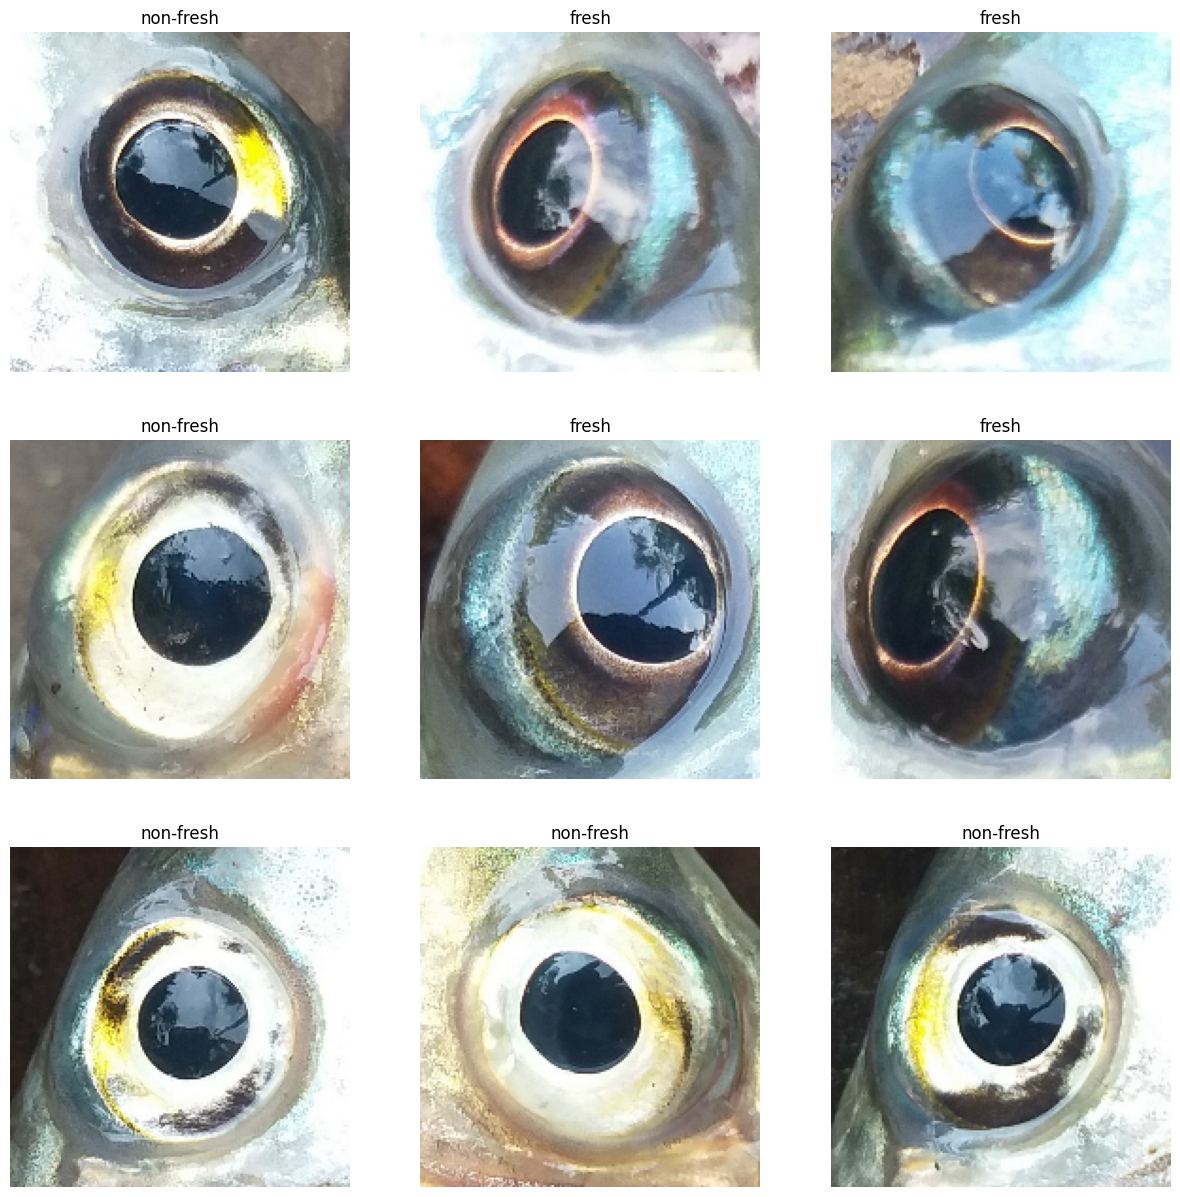

In [28]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off") 

In [29]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
t1 = time.time()
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)
t2 = time.time()
print(t2-t1)

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.6895 - accuracy: 0.5312 - val_loss: 1.5553 - val_accuracy: 0.3750
Epoch 2/20
1/1 [==============================] - 0s 43ms/step - loss: 1.1995 - accuracy: 0.5312 - val_loss: 0.5985 - val_accuracy: 0.6250
Epoch 3/20
1/1 [==============================] - 0s 45ms/step - loss: 0.5868 - accuracy: 0.9375 - val_loss: 0.6443 - val_accuracy: 0.6250
Epoch 4/20
1/1 [==============================] - 0s 45ms/step - loss: 0.6887 - accuracy: 0.4688 - val_loss: 0.6193 - val_accuracy: 0.6250
Epoch 5/20
1/1 [==============================] - 0s 46ms/step - loss: 0.6209 - accuracy: 0.5625 - val_loss: 0.6109 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 44ms/step - loss: 0.5650 - accuracy: 1.0000 - val_loss: 0.6139 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 43ms/step - loss: 0.5359 - accuracy: 0.7500 - val_loss: 0.5994 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=============